In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

False


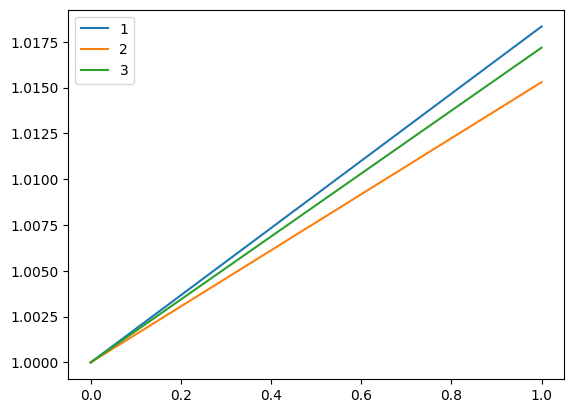

In [3]:
N_NEEDED = 5
N_AT_TOP = 3

perf1 = np.array([98525,100331])
perf2 = np.array([97888, 99385])
perf3 = np.array([97642, 99319])

MUTATE = len(perf1) - 1 >= N_NEEDED
print(MUTATE)

buying_power = [141128, 146577, 144301]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
BEST = 1  # [1, 2, 3]
MUTATE_SCALE = 0.5

In [5]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAON,82.139999,0,0.093525,0.906475,0.163752,0.016304,0.673007
1,AAPL,213.490005,0,0.029576,0.970424,0.022258,0.066890,0.858195
2,ABBV,211.770004,1,0.817346,0.182654,0.701113,0.776338,0.775572
3,ABNB,122.860001,0,0.090995,0.909005,0.045837,0.200000,0.165418
4,ACN,318.820007,0,0.001599,0.998401,0.011924,0.053512,0.703996


In [6]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [7]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [8]:
len(states)

3

In [9]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [10]:
if MUTATE:
    print('mutating..')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [11]:
len(mods)

3

In [12]:
#for mod in mods:
#    print(mod.Ws)

In [13]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [14]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
AAPL,853.96,640.47,853.96
ABBV,635.31,635.31,847.08
ABT,506.84,0.00,0.00
AJG,650.48,650.48,650.48
AMD,807.76,807.76,0.00


In [15]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAON,82.14,0.004285,0.004365,0.004090
1,AAPL,213.49,0.004404,0.004495,0.004115
2,ABBV,211.77,0.004340,0.004472,0.004099
3,ABNB,122.86,0.004036,0.003813,0.004039
4,ACN,318.82,0.004374,0.004457,0.004108


In [16]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[200662.78, 198769.62, 198637.47999999998]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAON,82.14,0.004285,0.004365,0.004090,859.83,867.63,812.33
AAPL,213.49,0.004404,0.004495,0.004115,883.79,893.54,817.43
ABBV,211.77,0.004340,0.004472,0.004099,870.90,888.96,814.22
ABNB,122.86,0.004036,0.003813,0.004039,809.82,757.95,802.20
ACN,318.82,0.004374,0.004457,0.004108,877.61,886.00,816.01


In [17]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAON,82.14,0.004285,0.004365,0.004090,859.83,867.63,812.33,0.00,0.00,0.00
AAPL,213.49,0.004404,0.004495,0.004115,883.79,893.54,817.43,853.96,640.47,853.96
ABBV,211.77,0.004340,0.004472,0.004099,870.90,888.96,814.22,635.31,635.31,847.08
ABNB,122.86,0.004036,0.003813,0.004039,809.82,757.95,802.20,0.00,0.00,0.00
ACN,318.82,0.004374,0.004457,0.004108,877.61,886.00,816.01,0.00,0.00,0.00


In [18]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAON,82.14,0.004285,0.004365,0.004090,859.83,867.63,812.33,0.00,0.00,0.00,859.83,867.63,812.33
AAPL,213.49,0.004404,0.004495,0.004115,883.79,893.54,817.43,853.96,640.47,853.96,29.83,253.07,-36.53
ABBV,211.77,0.004340,0.004472,0.004099,870.90,888.96,814.22,635.31,635.31,847.08,235.59,253.65,-32.86
ABNB,122.86,0.004036,0.003813,0.004039,809.82,757.95,802.20,0.00,0.00,0.00,809.82,757.95,802.20
ACN,318.82,0.004374,0.004457,0.004108,877.61,886.00,816.01,0.00,0.00,0.00,877.61,886.00,816.01


In [19]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [20]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAON,82.14,0.004285,0.004365,0.004090,859.83,867.63,812.33,0.00,0.00,0.00,859.83,867.63,812.33,10,11,10
AAPL,213.49,0.004404,0.004495,0.004115,883.79,893.54,817.43,853.96,640.47,853.96,29.83,253.07,-36.53,0,1,0
ABBV,211.77,0.004340,0.004472,0.004099,870.90,888.96,814.22,635.31,635.31,847.08,235.59,253.65,-32.86,1,1,0
ABNB,122.86,0.004036,0.003813,0.004039,809.82,757.95,802.20,0.00,0.00,0.00,809.82,757.95,802.20,7,6,7
ACN,318.82,0.004374,0.004457,0.004108,877.61,886.00,816.01,0.00,0.00,0.00,877.61,886.00,816.01,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WTRG,39.50,0.003580,0.003669,0.004036,718.42,729.35,801.75,513.50,0.00,0.00,204.92,729.35,801.75,5,18,20
XPEV,23.73,0.004127,0.004289,0.004063,828.08,852.61,807.14,593.25,0.00,0.00,234.83,852.61,807.14,10,36,34
XYL,122.76,0.004373,0.004459,0.004103,877.48,886.27,814.94,859.32,0.00,0.00,18.16,886.27,814.94,0,7,7


In [21]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
ACN,318.82,877.61,3
TYL,563.38,877.55,2
SMLR,34.35,877.10,26
IDXX,415.30,877.08,2
FIVN,29.48,876.75,30


In [23]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
GEHC,81.97,57.49,1
FAST,75.26,46.61,1
CSCO,60.50,34.45,1
BYRN,20.85,26.75,1
SERV,7.66,22.55,3


In [24]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
SERV,7.66,890.00,116
BYRN,20.85,889.61,43
PCTY,186.24,887.04,5
XYL,122.76,886.27,7
TYL,563.38,886.09,2


In [25]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
APO,134.32,83.79,1
AMD,100.97,76.07,1
SMTI,32.39,72.72,2
KO,69.16,59.43,1
CSCO,60.50,42.49,1


In [26]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
DPZ,425.58,816.44,2
WING,213.20,816.10,4
ACN,318.82,816.01,3
PCTY,186.24,815.77,4
AMD,100.97,815.76,8


In [27]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
GEHC,81.97,-86.14,-1
FAST,75.26,-88.93,-1
CSCO,60.50,-91.20,-2
SMTI,32.39,-125.29,-4
LRCX,78.69,-128.23,-2


In [28]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

Did nothing
